<a href="https://colab.research.google.com/github/haikalfitri/EMNIST/blob/main/Emnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Jul 24 13:30:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    29W /  70W |    816MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
import os
src = 'drive/MyDrive/emnist-balanced.mat'
dst =  'emnist-balanced.mat'
shutil.copyfile(src, dst)

'emnist-balanced.mat'

In [ ]:
from scipy import io as spio
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras as keras

import cv2

import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model
import numpy as np
import seaborn as sns

import pickle

#Load Data

In [ ]:
data = spio.loadmat("emnist-balanced.mat")

x_train = data["dataset"][0][0][0][0][0][0]
y_train = data["dataset"][0][0][0][0][0][1]

x_test = data["dataset"][0][0][1][0][0][0]
y_test = data["dataset"][0][0][1][0][0][1]


In [ ]:
x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)

#Preprocess Data

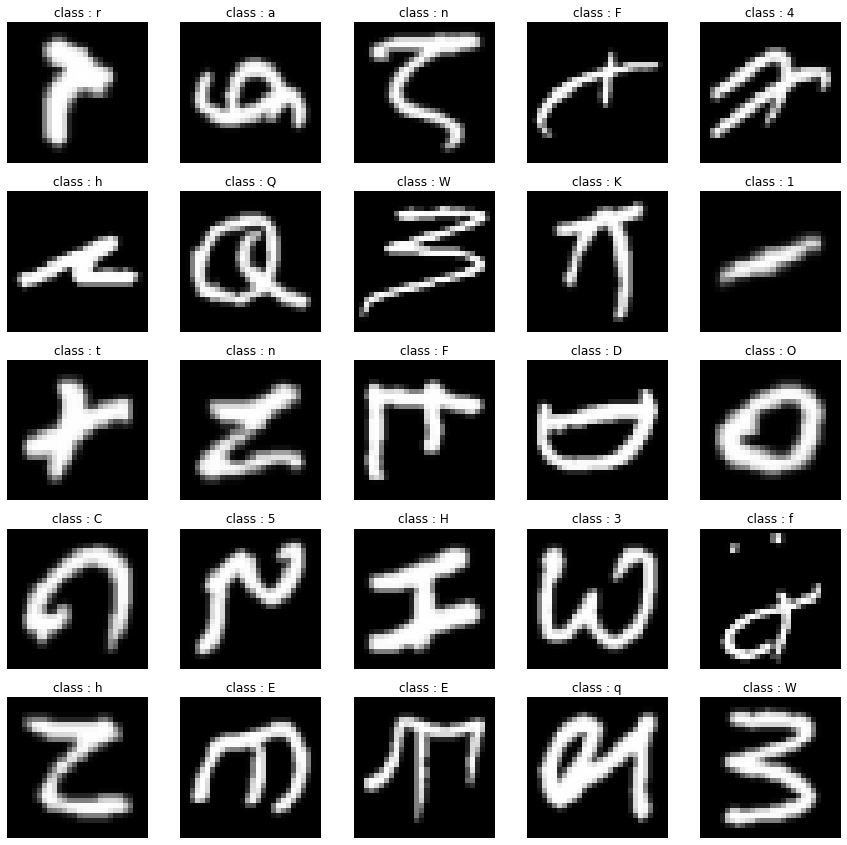

In [ ]:

emnist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

f, ax = plt.subplots(5, 5, figsize = (15, 15))
for i in range(0,25):
    
    label = emnist[y_train[i][0]]
    ax[i//5, i%5].imshow(tf.squeeze(x_train[i]), cmap='gray')
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("class : {}".format(label)) 
plt.show()

In [ ]:
import numpy as np
for i in range(x_train.shape[0]):
    x_train[i] = np.rot90(np.fliplr(x_train[i]))

for i in range(x_test.shape[0]):
    x_test[i] = np.rot90(np.fliplr(x_test[i]))

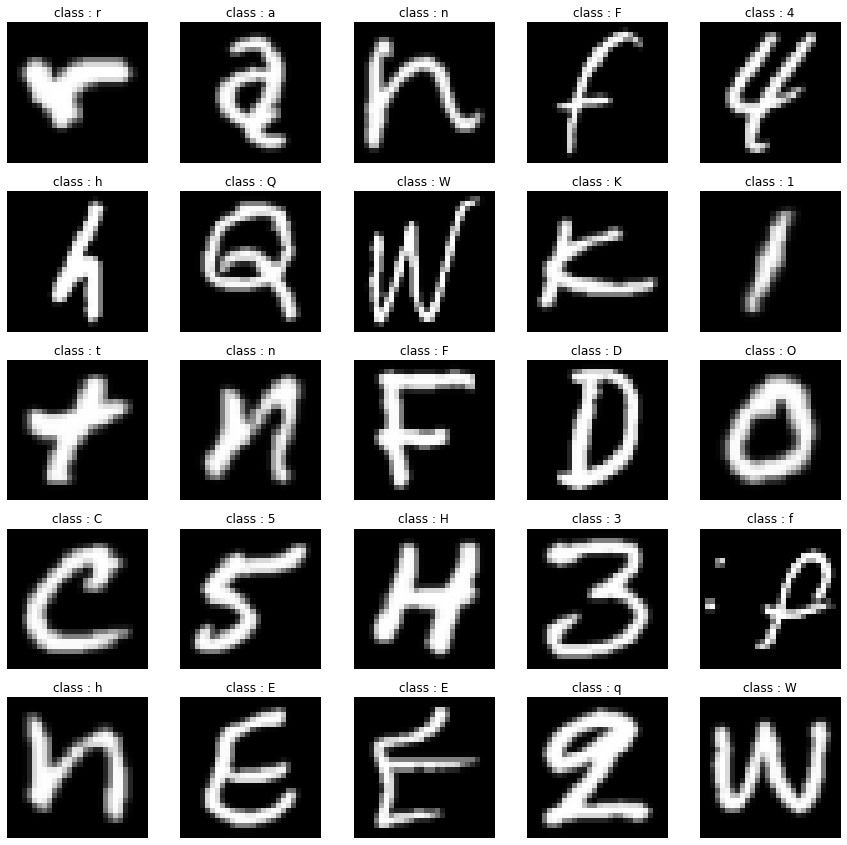

In [ ]:

emnist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

f, ax = plt.subplots(5, 5, figsize = (15, 15))
for i in range(0,25):
    
    label = emnist[y_train[i][0]]
    ax[i//5, i%5].imshow(tf.squeeze(x_train[i]), cmap='gray')
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("class : {}".format(label)) 
plt.show()

In [ ]:
#Normalize Data
x_train = x_train / 255 
x_test = x_test / 255

#Reshape labels into categories

In [ ]:
y_train = keras.utils.to_categorical(y_train, 47)
y_test = keras.utils.to_categorical(y_test, 47)

#Image Augmentation 1

In [ ]:
data_generator1 = ImageDataGenerator(
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=.1)

#Image Augmentation 2

In [ ]:
data_generator2 = ImageDataGenerator(
                        fill_mode='nearest',
                        rotation_range=0.2,
                        zoom_range=.1)

#Design ANN model

In [ ]:
model=Sequential()


model.add(Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(64,(3,3), activation='relu'))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(47, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               2

#Experiment 1

In [ ]:
epoch = 35
optimizer = 'adam'


NAME = "{}-optimizer-{}-epoch".format(optimizer,epoch)

BASE_SAVE_DIR = "/content/drive/MyDrive/Emnist_Training/"

BASE_LOGS_DIR = "/content/drive/MyDrive/Emnist_Training/logs"

tensorboard = TensorBoard(log_dir="{}/{}".format(BASE_LOGS_DIR,NAME))

#mcp_save = ModelCheckpoint(BASE_SAVE_DIR + NAME + '/cp_model.h5', save_best_only=True, monitor='val_loss',verbose=1, mode='auto')

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              
#history = model.fit(data_generator.flow(x_train,y_train),validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32, epochs=epoch, callbacks=[tensorboard])
    

In [ ]:
model.save(BASE_SAVE_DIR + NAME + '/model.h5',save_format ='h5')

In [ ]:
train_evaluation = model.evaluate(x_train,y_train)
val_evaluation = model.evaluate(x_test,y_test)

In [ ]:
print("Loss of the model (train data) is - " , train_evaluation[0])
print("Accuracy of the model (train data) is - " , train_evaluation[1]*100 , "%")
print()
print("Loss of the model (validation data) is - " , val_evaluation[0])
print("Accuracy of the model (validation data) is - " , val_evaluation[1]*100 , "%")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('LOSS')

plt.savefig(BASE_SAVE_DIR + NAME +'/graph.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
class_predictions = np.argmax(model.predict(x_test), axis=-1)

emnist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

predict_classes = [emnist[i] for i in class_predictions]
actual_classes = [emnist[i] for i in np.argmax(y_test, axis=-1)]

out_df = pd.DataFrame(np.vstack([predict_classes,actual_classes]).T,columns=["predicted_class","actual_class"])
confusion_matrix = pd.crosstab(out_df["actual_class"],out_df["predicted_class"],rownames=["Actuals"],colnames=["Predicted"])
plt.figure(figsize=(22, 19))
sns.heatmap(confusion_matrix,cmap="Reds",annot=True,fmt='d')

plt.savefig(BASE_SAVE_DIR + NAME +'/confusion_matrix.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

#Experiment 2

In [ ]:
epoch = 35
optimizer = 'rmsprop'


NAME = "{}-optimizer-{}-epoch".format(optimizer,epoch)

BASE_SAVE_DIR = "/content/drive/MyDrive/Emnist_Training/"

BASE_LOGS_DIR = "/content/drive/MyDrive/Emnist_Training/logs"

tensorboard = TensorBoard(log_dir="{}/{}".format(BASE_LOGS_DIR,NAME))

#mcp_save = ModelCheckpoint(BASE_SAVE_DIR + NAME + '/cp_model.h5', save_best_only=True, monitor='val_loss',verbose=1, mode='auto')

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              
#history = model.fit(data_generator.flow(x_train,y_train),validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32, epochs=epoch, callbacks=[tensorboard])
    

Epoch 1/35
3525/3525 [==============================] - 29s 8ms/step - loss: 0.0839 - accuracy: 0.9676 - val_loss: 1.1329 - val_accuracy: 0.8669
Epoch 2/35
3525/3525 [==============================] - 26s 7ms/step - loss: 0.0894 - accuracy: 0.9660 - val_loss: 1.1289 - val_accuracy: 0.8678
Epoch 3/35
3525/3525 [==============================] - 26s 7ms/step - loss: 0.0998 - accuracy: 0.9638 - val_loss: 1.1521 - val_accuracy: 0.8671
Epoch 4/35
3525/3525 [==============================] - 27s 8ms/step - loss: 0.1177 - accuracy: 0.9582 - val_loss: 1.0263 - val_accuracy: 0.8631
Epoch 5/35
3525/3525 [==============================] - 26s 7ms/step - loss: 0.1409 - accuracy: 0.9514 - val_loss: 0.9773 - val_accuracy: 0.8663
Epoch 6/35
3525/3525 [==============================] - 27s 8ms/step - loss: 0.1810 - accuracy: 0.9401 - val_loss: 0.9663 - val_accuracy: 0.8609
Epoch 7/35
3525/3525 [==============================] - 27s 8ms/step - loss: 0.2305 - accuracy: 0.9268 - val_loss: 0.7475 - val_ac

In [ ]:
model.save(BASE_SAVE_DIR + NAME + '/model.h5',save_format ='h5')

In [ ]:
train_evaluation = model.evaluate(x_train,y_train)
val_evaluation = model.evaluate(x_test,y_test)

588/588 [==============================] - 2s 4ms/step - loss: 0.8284 - accuracy: 0.8177


In [ ]:
print("Loss of the model (train data) is - " , train_evaluation[0])
print("Accuracy of the model (train data) is - " , train_evaluation[1]*100 , "%")
print()
print("Loss of the model (validation data) is - " , val_evaluation[0])
print("Accuracy of the model (validation data) is - " , val_evaluation[1]*100 , "%")

Loss of the model (train data) is -  0.67067950963974
Accuracy of the model (train data) is -  83.19503664970398 %

Loss of the model (validation data) is -  0.8284155130386353
Accuracy of the model (validation data) is -  81.77127838134766 %


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('LOSS')

plt.savefig(BASE_SAVE_DIR + NAME +'/graph.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
class_predictions = np.argmax(model.predict(x_test), axis=-1)

emnist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

predict_classes = [emnist[i] for i in class_predictions]
actual_classes = [emnist[i] for i in np.argmax(y_test, axis=-1)]

out_df = pd.DataFrame(np.vstack([predict_classes,actual_classes]).T,columns=["predicted_class","actual_class"])
confusion_matrix = pd.crosstab(out_df["actual_class"],out_df["predicted_class"],rownames=["Actuals"],colnames=["Predicted"])
plt.figure(figsize=(22, 19))
sns.heatmap(confusion_matrix,cmap="Reds",annot=True,fmt='d')

plt.savefig(BASE_SAVE_DIR + NAME +'/confusion_matrix.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

#Experiment 3

In [ ]:
epoch = 35
optimizer = 'adamax'


NAME = "{}-optimizer-{}-epoch".format(optimizer,epoch)

BASE_SAVE_DIR = "/content/drive/MyDrive/Emnist_Training/"

BASE_LOGS_DIR = "/content/drive/MyDrive/Emnist_Training/logs"

tensorboard = TensorBoard(log_dir="{}/{}".format(BASE_LOGS_DIR,NAME))

#mcp_save = ModelCheckpoint(BASE_SAVE_DIR + NAME + '/cp_model.h5', save_best_only=True, monitor='val_loss',verbose=1, mode='auto')

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              
#history = model.fit(data_generator.flow(x_train,y_train),validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
history = model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size=32, epochs=epoch, callbacks=[tensorboard])
    

Epoch 1/35
3525/3525 [==============================] - 25s 7ms/step - loss: 0.4647 - accuracy: 0.8523 - val_loss: 0.5619 - val_accuracy: 0.8402
Epoch 2/35
3525/3525 [==============================] - 25s 7ms/step - loss: 0.4332 - accuracy: 0.8598 - val_loss: 0.4881 - val_accuracy: 0.8495
Epoch 3/35
3525/3525 [==============================] - 25s 7ms/step - loss: 0.4188 - accuracy: 0.8623 - val_loss: 0.5232 - val_accuracy: 0.8453
Epoch 4/35
3525/3525 [==============================] - 24s 7ms/step - loss: 0.4055 - accuracy: 0.8648 - val_loss: 0.4947 - val_accuracy: 0.8460
Epoch 5/35
3525/3525 [==============================] - 24s 7ms/step - loss: 0.3977 - accuracy: 0.8663 - val_loss: 0.5242 - val_accuracy: 0.8546
Epoch 6/35
3525/3525 [==============================] - 24s 7ms/step - loss: 0.3922 - accuracy: 0.8684 - val_loss: 0.5032 - val_accuracy: 0.8571
Epoch 7/35
3525/3525 [==============================] - 24s 7ms/step - loss: 0.3864 - accuracy: 0.8699 - val_loss: 0.4911 - val_ac

In [ ]:
model.save(BASE_SAVE_DIR + NAME + '/model.h5',save_format ='h5')

In [ ]:
train_evaluation = model.evaluate(x_train,y_train)
val_evaluation = model.evaluate(x_test,y_test)

588/588 [==============================] - 2s 4ms/step - loss: 0.4777 - accuracy: 0.8618


In [ ]:
print("Loss of the model (train data) is - " , train_evaluation[0])
print("Accuracy of the model (train data) is - " , train_evaluation[1]*100 , "%")
print()
print("Loss of the model (validation data) is - " , val_evaluation[0])
print("Accuracy of the model (validation data) is - " , val_evaluation[1]*100 , "%")

Loss of the model (train data) is -  0.2991774380207062
Accuracy of the model (train data) is -  89.05230760574341 %

Loss of the model (validation data) is -  0.4777216613292694
Accuracy of the model (validation data) is -  86.18085384368896 %


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('LOSS')

plt.savefig(BASE_SAVE_DIR + NAME +'/graph.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
class_predictions = np.argmax(model.predict(x_test), axis=-1)

emnist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

predict_classes = [emnist[i] for i in class_predictions]
actual_classes = [emnist[i] for i in np.argmax(y_test, axis=-1)]

out_df = pd.DataFrame(np.vstack([predict_classes,actual_classes]).T,columns=["predicted_class","actual_class"])
confusion_matrix = pd.crosstab(out_df["actual_class"],out_df["predicted_class"],rownames=["Actuals"],colnames=["Predicted"])
plt.figure(figsize=(22, 19))
sns.heatmap(confusion_matrix,cmap="Reds",annot=True,fmt='d')

plt.savefig(BASE_SAVE_DIR + NAME +'/confusion_matrix.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

#Experiment 4

In [ ]:
epoch = 35
optimizer = 'adam'


NAME = "{}-optimizer-{}-epoch-Image_Aug_1".format(optimizer,epoch)

BASE_SAVE_DIR = "/content/drive/MyDrive/Emnist_Training/"

BASE_LOGS_DIR = "/content/drive/MyDrive/Emnist_Training/logs"

tensorboard = TensorBoard(log_dir="{}/{}".format(BASE_LOGS_DIR,NAME))

#mcp_save = ModelCheckpoint(BASE_SAVE_DIR + NAME + '/cp_model.h5', save_best_only=True, monitor='val_loss',verbose=1, mode='auto')

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              
history = model.fit(data_generator1.flow(x_train,y_train),validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
#history = model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
    

Epoch 1/35
3525/3525 [==============================] - 65s 16ms/step - loss: 1.1771 - accuracy: 0.6337 - val_loss: 0.6029 - val_accuracy: 0.7951
Epoch 2/35
3525/3525 [==============================] - 56s 16ms/step - loss: 0.6713 - accuracy: 0.7724 - val_loss: 0.4977 - val_accuracy: 0.8283
Epoch 3/35
3525/3525 [==============================] - 56s 16ms/step - loss: 0.5921 - accuracy: 0.7973 - val_loss: 0.4439 - val_accuracy: 0.8494
Epoch 4/35
3525/3525 [==============================] - 56s 16ms/step - loss: 0.5448 - accuracy: 0.8116 - val_loss: 0.4387 - val_accuracy: 0.8462
Epoch 5/35
3525/3525 [==============================] - 56s 16ms/step - loss: 0.5179 - accuracy: 0.8184 - val_loss: 0.4578 - val_accuracy: 0.8390
Epoch 6/35
3525/3525 [==============================] - 56s 16ms/step - loss: 0.4964 - accuracy: 0.8260 - val_loss: 0.4004 - val_accuracy: 0.8598
Epoch 7/35
3525/3525 [==============================] - 56s 16ms/step - loss: 0.4796 - accuracy: 0.8304 - val_loss: 0.4058 -

In [ ]:
model.save(BASE_SAVE_DIR + NAME + '/model.h5',save_format ='h5')

In [ ]:
train_evaluation = model.evaluate(x_train,y_train)
val_evaluation = model.evaluate(x_test,y_test)

588/588 [==============================] - 2s 4ms/step - loss: 0.4090 - accuracy: 0.8649


In [ ]:
print("Loss of the model (train data) is - " , train_evaluation[0])
print("Accuracy of the model (train data) is - " , train_evaluation[1]*100 , "%")
print()
print("Loss of the model (validation data) is - " , val_evaluation[0])
print("Accuracy of the model (validation data) is - " , val_evaluation[1]*100 , "%")

Loss of the model (train data) is -  0.3469063341617584
Accuracy of the model (train data) is -  87.53014206886292 %

Loss of the model (validation data) is -  0.40895602107048035
Accuracy of the model (validation data) is -  86.48936152458191 %


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('LOSS')

plt.savefig(BASE_SAVE_DIR + NAME +'/graph.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
class_predictions = np.argmax(model.predict(x_test), axis=-1)

emnist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

predict_classes = [emnist[i] for i in class_predictions]
actual_classes = [emnist[i] for i in np.argmax(y_test, axis=-1)]

out_df = pd.DataFrame(np.vstack([predict_classes,actual_classes]).T,columns=["predicted_class","actual_class"])
confusion_matrix = pd.crosstab(out_df["actual_class"],out_df["predicted_class"],rownames=["Actuals"],colnames=["Predicted"])
plt.figure(figsize=(22, 19))
sns.heatmap(confusion_matrix,cmap="Reds",annot=True,fmt='d')

plt.savefig(BASE_SAVE_DIR + NAME +'/confusion_matrix.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

#Experiment 5

In [ ]:
epoch = 35
optimizer = 'rmsprop'


NAME = "{}-optimizer-{}-epoch-Image_Aug_1".format(optimizer,epoch)

BASE_SAVE_DIR = "/content/drive/MyDrive/Emnist_Training/"

BASE_LOGS_DIR = "/content/drive/MyDrive/Emnist_Training/logs"

tensorboard = TensorBoard(log_dir="{}/{}".format(BASE_LOGS_DIR,NAME))

#mcp_save = ModelCheckpoint(BASE_SAVE_DIR + NAME + '/cp_model.h5', save_best_only=True, monitor='val_loss',verbose=1, mode='auto')

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              
history = model.fit(data_generator1.flow(x_train,y_train),validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
#history = model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
    

Epoch 1/35
3525/3525 [==============================] - 60s 17ms/step - loss: 0.4243 - accuracy: 0.8536 - val_loss: 0.4745 - val_accuracy: 0.8563
Epoch 2/35
3525/3525 [==============================] - 58s 16ms/step - loss: 0.4963 - accuracy: 0.8404 - val_loss: 0.5893 - val_accuracy: 0.8522
Epoch 3/35
3525/3525 [==============================] - 57s 16ms/step - loss: 0.5694 - accuracy: 0.8229 - val_loss: 1.0277 - val_accuracy: 0.8476
Epoch 4/35
3525/3525 [==============================] - 58s 16ms/step - loss: 0.6200 - accuracy: 0.8109 - val_loss: 4.6985 - val_accuracy: 0.8064
Epoch 5/35
3525/3525 [==============================] - 57s 16ms/step - loss: 0.6626 - accuracy: 0.8001 - val_loss: 0.8457 - val_accuracy: 0.8360
Epoch 6/35
3525/3525 [==============================] - 57s 16ms/step - loss: 0.6996 - accuracy: 0.7909 - val_loss: 1.5204 - val_accuracy: 0.8372
Epoch 7/35
3525/3525 [==============================] - 57s 16ms/step - loss: 0.7256 - accuracy: 0.7841 - val_loss: 1.0239 -

In [ ]:
model.save(BASE_SAVE_DIR + NAME + '/model.h5',save_format ='h5')

In [ ]:
train_evaluation = model.evaluate(x_train,y_train)
val_evaluation = model.evaluate(x_test,y_test)

588/588 [==============================] - 2s 4ms/step - loss: 4.0131 - accuracy: 0.7389


In [ ]:
print("Loss of the model (train data) is - " , train_evaluation[0])
print("Accuracy of the model (train data) is - " , train_evaluation[1]*100 , "%")
print()
print("Loss of the model (validation data) is - " , val_evaluation[0])
print("Accuracy of the model (validation data) is - " , val_evaluation[1]*100 , "%")

Loss of the model (train data) is -  2.8703582286834717
Accuracy of the model (train data) is -  74.1374135017395 %

Loss of the model (validation data) is -  4.013098239898682
Accuracy of the model (validation data) is -  73.8936185836792 %


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('LOSS')

plt.savefig(BASE_SAVE_DIR + NAME +'/graph.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
class_predictions = np.argmax(model.predict(x_test), axis=-1)

emnist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

predict_classes = [emnist[i] for i in class_predictions]
actual_classes = [emnist[i] for i in np.argmax(y_test, axis=-1)]

out_df = pd.DataFrame(np.vstack([predict_classes,actual_classes]).T,columns=["predicted_class","actual_class"])
confusion_matrix = pd.crosstab(out_df["actual_class"],out_df["predicted_class"],rownames=["Actuals"],colnames=["Predicted"])
plt.figure(figsize=(22, 19))
sns.heatmap(confusion_matrix,cmap="Reds",annot=True,fmt='d')

plt.savefig(BASE_SAVE_DIR + NAME +'/confusion_matrix.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()



#Experiment 6

In [ ]:
epoch = 35
optimizer = 'adamax'


NAME = "{}-optimizer-{}-epoch-Image_Aug_1".format(optimizer,epoch)

BASE_SAVE_DIR = "/content/drive/MyDrive/Emnist_Training/"

BASE_LOGS_DIR = "/content/drive/MyDrive/Emnist_Training/logs"

tensorboard = TensorBoard(log_dir="{}/{}".format(BASE_LOGS_DIR,NAME))

#mcp_save = ModelCheckpoint(BASE_SAVE_DIR + NAME + '/cp_model.h5', save_best_only=True, monitor='val_loss',verbose=1, mode='auto')

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              
history = model.fit(data_generator1.flow(x_train,y_train),validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
#history = model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
    

Epoch 1/35
3525/3525 [==============================] - 60s 17ms/step - loss: 0.9499 - accuracy: 0.7287 - val_loss: 2.6692 - val_accuracy: 0.7863
Epoch 2/35
3525/3525 [==============================] - 58s 17ms/step - loss: 0.8932 - accuracy: 0.7407 - val_loss: 2.2538 - val_accuracy: 0.8056
Epoch 3/35
3525/3525 [==============================] - 59s 17ms/step - loss: 0.9003 - accuracy: 0.7478 - val_loss: 1.9673 - val_accuracy: 0.8032
Epoch 4/35
3525/3525 [==============================] - 58s 16ms/step - loss: 0.8313 - accuracy: 0.7511 - val_loss: 2.1072 - val_accuracy: 0.7985
Epoch 5/35
3525/3525 [==============================] - 59s 17ms/step - loss: 0.8197 - accuracy: 0.7564 - val_loss: 1.8897 - val_accuracy: 0.8047
Epoch 6/35
3525/3525 [==============================] - 58s 17ms/step - loss: 0.8005 - accuracy: 0.7604 - val_loss: 1.6767 - val_accuracy: 0.8085
Epoch 7/35
3525/3525 [==============================] - 57s 16ms/step - loss: 0.7989 - accuracy: 0.7587 - val_loss: 1.6312 -

In [ ]:
model.save(BASE_SAVE_DIR + NAME + '/model.h5',save_format ='h5')

In [ ]:
train_evaluation = model.evaluate(x_train,y_train)
val_evaluation = model.evaluate(x_test,y_test)

588/588 [==============================] - 2s 4ms/step - loss: 0.6826 - accuracy: 0.8299


In [ ]:
print("Loss of the model (train data) is - " , train_evaluation[0])
print("Accuracy of the model (train data) is - " , train_evaluation[1]*100 , "%")
print()
print("Loss of the model (validation data) is - " , val_evaluation[0])
print("Accuracy of the model (validation data) is - " , val_evaluation[1]*100 , "%")

Loss of the model (train data) is -  0.6374857425689697
Accuracy of the model (train data) is -  83.59840512275696 %

Loss of the model (validation data) is -  0.6825701594352722
Accuracy of the model (validation data) is -  82.98935890197754 %


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('LOSS')

plt.savefig(BASE_SAVE_DIR + NAME +'/graph.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
class_predictions = np.argmax(model.predict(x_test), axis=-1)

emnist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

predict_classes = [emnist[i] for i in class_predictions]
actual_classes = [emnist[i] for i in np.argmax(y_test, axis=-1)]

out_df = pd.DataFrame(np.vstack([predict_classes,actual_classes]).T,columns=["predicted_class","actual_class"])
confusion_matrix = pd.crosstab(out_df["actual_class"],out_df["predicted_class"],rownames=["Actuals"],colnames=["Predicted"])
plt.figure(figsize=(22, 19))
sns.heatmap(confusion_matrix,cmap="Reds",annot=True,fmt='d')

plt.savefig(BASE_SAVE_DIR + NAME +'/confusion_matrix.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()



#Experiment 7

In [ ]:
epoch = 35
optimizer = 'adam'


NAME = "{}-optimizer-{}-epoch-Image_Aug_2".format(optimizer,epoch)

BASE_SAVE_DIR = "/content/drive/MyDrive/Emnist_Training/"

BASE_LOGS_DIR = "/content/drive/MyDrive/Emnist_Training/logs"

tensorboard = TensorBoard(log_dir="{}/{}".format(BASE_LOGS_DIR,NAME))

#mcp_save = ModelCheckpoint(BASE_SAVE_DIR + NAME + '/cp_model.h5', save_best_only=True, monitor='val_loss',verbose=1, mode='auto')

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              
history = model.fit(data_generator2.flow(x_train,y_train),validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
#history = model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
    

Epoch 1/35
3525/3525 [==============================] - 76s 15ms/step - loss: 0.6627 - accuracy: 0.7835 - val_loss: 0.4648 - val_accuracy: 0.8347
Epoch 2/35
3525/3525 [==============================] - 53s 15ms/step - loss: 0.3943 - accuracy: 0.8570 - val_loss: 0.4052 - val_accuracy: 0.8522
Epoch 3/35
3525/3525 [==============================] - 51s 15ms/step - loss: 0.3466 - accuracy: 0.8714 - val_loss: 0.3764 - val_accuracy: 0.8707
Epoch 4/35
3525/3525 [==============================] - 52s 15ms/step - loss: 0.3175 - accuracy: 0.8808 - val_loss: 0.3628 - val_accuracy: 0.8750
Epoch 5/35
3525/3525 [==============================] - 52s 15ms/step - loss: 0.2950 - accuracy: 0.8862 - val_loss: 0.3657 - val_accuracy: 0.8740
Epoch 6/35
3525/3525 [==============================] - 51s 15ms/step - loss: 0.2778 - accuracy: 0.8920 - val_loss: 0.3838 - val_accuracy: 0.8723
Epoch 7/35
3525/3525 [==============================] - 52s 15ms/step - loss: 0.2613 - accuracy: 0.8974 - val_loss: 0.3670 -

In [ ]:
model.save(BASE_SAVE_DIR + NAME + '/model.h5',save_format ='h5')

In [ ]:
train_evaluation = model.evaluate(x_train,y_train)
val_evaluation = model.evaluate(x_test,y_test)

588/588 [==============================] - 2s 4ms/step - loss: 0.7379 - accuracy: 0.8686


In [ ]:
print("Loss of the model (train data) is - " , train_evaluation[0])
print("Accuracy of the model (train data) is - " , train_evaluation[1]*100 , "%")
print()
print("Loss of the model (validation data) is - " , val_evaluation[0])
print("Accuracy of the model (validation data) is - " , val_evaluation[1]*100 , "%")

Loss of the model (train data) is -  0.1271374374628067
Accuracy of the model (train data) is -  94.70921754837036 %

Loss of the model (validation data) is -  0.7379473447799683
Accuracy of the model (validation data) is -  86.86169981956482 %


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('LOSS')

plt.savefig(BASE_SAVE_DIR + NAME +'/graph.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
class_predictions = np.argmax(model.predict(x_test), axis=-1)

emnist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

predict_classes = [emnist[i] for i in class_predictions]
actual_classes = [emnist[i] for i in np.argmax(y_test, axis=-1)]

out_df = pd.DataFrame(np.vstack([predict_classes,actual_classes]).T,columns=["predicted_class","actual_class"])
confusion_matrix = pd.crosstab(out_df["actual_class"],out_df["predicted_class"],rownames=["Actuals"],colnames=["Predicted"])
plt.figure(figsize=(22, 19))
sns.heatmap(confusion_matrix,cmap="Reds",annot=True,fmt='d')

plt.savefig(BASE_SAVE_DIR + NAME +'/confusion_matrix.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()



#Experiment 8

In [ ]:
epoch = 35
optimizer = 'rmsprop'


NAME = "{}-optimizer-{}-epoch-Image_Aug_2".format(optimizer,epoch)

BASE_SAVE_DIR = "/content/drive/MyDrive/Emnist_Training/"

BASE_LOGS_DIR = "/content/drive/MyDrive/Emnist_Training/logs"

tensorboard = TensorBoard(log_dir="{}/{}".format(BASE_LOGS_DIR,NAME))

#mcp_save = ModelCheckpoint(BASE_SAVE_DIR + NAME + '/cp_model.h5', save_best_only=True, monitor='val_loss',verbose=1, mode='auto')

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              
history = model.fit(data_generator2.flow(x_train,y_train),validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
#history = model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
    

Epoch 1/35
3525/3525 [==============================] - 55s 15ms/step - loss: 0.1495 - accuracy: 0.9408 - val_loss: 0.8079 - val_accuracy: 0.8763
Epoch 2/35
3525/3525 [==============================] - 53s 15ms/step - loss: 0.1882 - accuracy: 0.9291 - val_loss: 0.9349 - val_accuracy: 0.8669
Epoch 3/35
3525/3525 [==============================] - 53s 15ms/step - loss: 0.2383 - accuracy: 0.9149 - val_loss: 0.8013 - val_accuracy: 0.8710
Epoch 4/35
3525/3525 [==============================] - 53s 15ms/step - loss: 0.2916 - accuracy: 0.9018 - val_loss: 0.6618 - val_accuracy: 0.8618
Epoch 5/35
3525/3525 [==============================] - 53s 15ms/step - loss: 0.3405 - accuracy: 0.8884 - val_loss: 0.7405 - val_accuracy: 0.8569
Epoch 6/35
3525/3525 [==============================] - 53s 15ms/step - loss: 0.3726 - accuracy: 0.8796 - val_loss: 0.9126 - val_accuracy: 0.8599
Epoch 7/35
3525/3525 [==============================] - 53s 15ms/step - loss: 0.3948 - accuracy: 0.8745 - val_loss: 1.1137 -

In [ ]:
model.save(BASE_SAVE_DIR + NAME + '/model.h5',save_format ='h5')

In [ ]:
train_evaluation = model.evaluate(x_train,y_train)
val_evaluation = model.evaluate(x_test,y_test)

588/588 [==============================] - 2s 4ms/step - loss: 1.3131 - accuracy: 0.8000


In [ ]:
print("Loss of the model (train data) is - " , train_evaluation[0])
print("Accuracy of the model (train data) is - " , train_evaluation[1]*100 , "%")
print()
print("Loss of the model (validation data) is - " , val_evaluation[0])
print("Accuracy of the model (validation data) is - " , val_evaluation[1]*100 , "%")

Loss of the model (train data) is -  1.0706744194030762
Accuracy of the model (train data) is -  80.82712888717651 %

Loss of the model (validation data) is -  1.313138484954834
Accuracy of the model (validation data) is -  80.0000011920929 %


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('LOSS')

plt.savefig(BASE_SAVE_DIR + NAME +'/graph.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
class_predictions = np.argmax(model.predict(x_test), axis=-1)

emnist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

predict_classes = [emnist[i] for i in class_predictions]
actual_classes = [emnist[i] for i in np.argmax(y_test, axis=-1)]

out_df = pd.DataFrame(np.vstack([predict_classes,actual_classes]).T,columns=["predicted_class","actual_class"])
confusion_matrix = pd.crosstab(out_df["actual_class"],out_df["predicted_class"],rownames=["Actuals"],colnames=["Predicted"])
plt.figure(figsize=(22, 19))
sns.heatmap(confusion_matrix,cmap="Reds",annot=True,fmt='d')

plt.savefig(BASE_SAVE_DIR + NAME +'/confusion_matrix.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()



#Experiment 9

In [ ]:
epoch = 35
optimizer = 'adamax'


NAME = "{}-optimizer-{}-epoch--Image_Aug_2".format(optimizer,epoch)

BASE_SAVE_DIR = "/content/drive/MyDrive/Emnist_Training/"

BASE_LOGS_DIR = "/content/drive/MyDrive/Emnist_Training/logs"

tensorboard = TensorBoard(log_dir="{}/{}".format(BASE_LOGS_DIR,NAME))

#mcp_save = ModelCheckpoint(BASE_SAVE_DIR + NAME + '/cp_model.h5', save_best_only=True, monitor='val_loss',verbose=1, mode='auto')

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              
history = model.fit(data_generator2.flow(x_train,y_train),validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
#history = model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epoch, callbacks=[tensorboard])
    

Epoch 1/35
3525/3525 [==============================] - 53s 15ms/step - loss: 0.4830 - accuracy: 0.8472 - val_loss: 0.8208 - val_accuracy: 0.8431
Epoch 2/35
3525/3525 [==============================] - 51s 14ms/step - loss: 0.4506 - accuracy: 0.8550 - val_loss: 0.7461 - val_accuracy: 0.8502
Epoch 3/35
3525/3525 [==============================] - 50s 14ms/step - loss: 0.4436 - accuracy: 0.8552 - val_loss: 0.6205 - val_accuracy: 0.8508
Epoch 4/35
3525/3525 [==============================] - 50s 14ms/step - loss: 0.4308 - accuracy: 0.8585 - val_loss: 0.6318 - val_accuracy: 0.8486
Epoch 5/35
3525/3525 [==============================] - 51s 14ms/step - loss: 0.4231 - accuracy: 0.8595 - val_loss: 0.5877 - val_accuracy: 0.8522
Epoch 6/35
3525/3525 [==============================] - 52s 15ms/step - loss: 0.4156 - accuracy: 0.8603 - val_loss: 0.6080 - val_accuracy: 0.8589
Epoch 7/35
3525/3525 [==============================] - 51s 14ms/step - loss: 0.4057 - accuracy: 0.8634 - val_loss: 0.5616 -

In [ ]:
model.save(BASE_SAVE_DIR + NAME + '/model.h5',save_format ='h5')

In [ ]:
train_evaluation = model.evaluate(x_train,y_train)
val_evaluation = model.evaluate(x_test,y_test)

In [ ]:
print("Loss of the model (train data) is - " , train_evaluation[0])
print("Accuracy of the model (train data) is - " , train_evaluation[1]*100 , "%")
print()
print("Loss of the model (validation data) is - " , val_evaluation[0])
print("Accuracy of the model (validation data) is - " , val_evaluation[1]*100 , "%")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('LOSS')

plt.savefig(BASE_SAVE_DIR + NAME +'/graph.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
class_predictions = np.argmax(model.predict(x_test), axis=-1)

emnist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

predict_classes = [emnist[i] for i in class_predictions]
actual_classes = [emnist[i] for i in np.argmax(y_test, axis=-1)]

out_df = pd.DataFrame(np.vstack([predict_classes,actual_classes]).T,columns=["predicted_class","actual_class"])
confusion_matrix = pd.crosstab(out_df["actual_class"],out_df["predicted_class"],rownames=["Actuals"],colnames=["Predicted"])
plt.figure(figsize=(22, 19))
sns.heatmap(confusion_matrix,cmap="Reds",annot=True,fmt='d')

plt.savefig(BASE_SAVE_DIR + NAME +'/confusion_matrix.jpg')
plt.clf()
plt.cla()
plt.close()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

#Model test/evaluation


In [ ]:
augs = ["","Image_Aug_1","Image_Aug_2"]
opts = ["adam","rmsprop","adamax"]
epoch = 35
models = []

for aug in augs:
  for opt in opts:
    if aug == "":
      NAME = "{}-optimizer-{}-epoch".format(opt,epoch)
    else:
      NAME = "{}-optimizer-{}-epoch-{}".format(opt,epoch,aug)

    if aug == "Image_Aug_2" and opt == "adamax":
      NAME = "{}-optimizer-{}-epoch--{}".format(opt,epoch,aug)

    BASE_SAVE_DIR = "/content/drive/MyDrive/Emnist_Training/"

    models.append(load_model(BASE_SAVE_DIR + NAME + '/model.h5'))

In [ ]:
for i in range(len(models)):
  print("################################################################################################")
  print("Experiment {} : ".format(i+1))
  print()
  train_evaluation = models[i].evaluate(x_train,y_train)
  val_evaluation = models[i].evaluate(x_test,y_test)
  print()
  print("Loss of the model (train data) is - " , train_evaluation[0])
  print("Accuracy of the model (train data) is - " , train_evaluation[1]*100 , "%")
  print()
  print("Loss of the model (validation data) is - " , val_evaluation[0])
  print("Accuracy of the model (validation data) is - " , val_evaluation[1]*100 , "%")
  print("################################################################################################")

################################################################################################
Experiment 1 : 

588/588 [==============================] - 3s 4ms/step - loss: 0.9172 - accuracy: 0.8665

Loss of the model (train data) is -  0.08196332305669785
Accuracy of the model (train data) is -  96.67819142341614 %

Loss of the model (validation data) is -  0.9171789884567261
Accuracy of the model (validation data) is -  86.64893507957458 %
################################################################################################
################################################################################################
Experiment 2 : 

588/588 [==============================] - 3s 4ms/step - loss: 0.8284 - accuracy: 0.8177

Loss of the model (train data) is -  0.6706795692443848
Accuracy of the model (train data) is -  83.19503664970398 %

Loss of the model (validation data) is -  0.8284156918525696
Accuracy of the model (validation data) is -  81.77127838134766 %
####

In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()
print(uploaded)

Saving Untitled.png to Untitled.png
{'Untitled.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x02\x00\x00\x00\xfdoH\xc3\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x0e\xc3\x00\x00\x0e\xc3\x01\xc7o\xa8d\x00\x00\x02\tIDATHK\xed\x95\xbd\x8faQ\x18\xc6\xd9l\x88\x8f\xf8\x8al\x14\x12\xa1\xd3\tB#\x1a\x95D\xf4*\x7f\x81^"AD\xa9\xf7\'h4\x124BF3!BD$JDcb2\xecl$\x86\xcb\x9dw\xe6}w\xf6\xde\x9d\xbd\xf7La\x9a\xc9\xfe\x8a\xe3>\xcf\xfb\x9e\xc7q\xce\xcd\xa1\xe4y^qm\xbe\xd1\xe7U\xf9b\xa1\xf5z\xbdR\xa9\x90\xf8\x08pPLt:\x1dtV\xabU\xd2,\xd8\xa1\xbd^\x0f\xbf\xde\xe3\xf1\x90\xc5\x82\xfd\xf3\xbb\xdd.\x8cV\xabu<\x1e\x17\n\x054\x19P\xb84\xb1X\x0c\xda\xd2\xe94\xf6\xafV+*H\xc3\x0e\xb5X,\x90\xb5\\.\x13\x89\x04<d2\x19*H\xc3\x08\x9dL&\x10\xe4r\xb9\xe0\x19\xf7\xc1f\xb3aI\x06\xc6\x9e\xe2)\x05\x02\x01\x18\xc3\xe1\xb0\xdb\xed^\xaf\xd7\x98.\xc3\x87B\x83\xc1 J\xdc\xdff\xb3\x89\x12\x81\xa5\x9dN\xdc\xf1\xc4].\x97?\x96\x0cN\x

In [ ]:
print(uploaded)

{'Untitled.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x02\x00\x00\x00\xfdoH\xc3\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x0e\xc3\x00\x00\x0e\xc3\x01\xc7o\xa8d\x00\x00\x01\x9aIDATHK\xed\x95\xb1\x8a\xc2@\x10\x86\xf7\x0c6B@\x05E\x08\x01%\x8dG\xd0V\xcb`c\x93\'PHga\xe7;h\x11\xb0\xcd3X\xd8\'\xa0X\x89\x85\xf6\x92R\x0b\xd1FQ\x08\x086\xb27\xe7\x0ewM&\xb9"\xcd\x81_\xb1\xc9\xfc3\xfbg7\xb3$\x1f\x9cs\x964)\xbc&\xca\xff1\x8d\x7f\xa7\x9b\xcd\xe6x<~\xbe@)\x160\x8d\xa0^\xafc\x1dc\xc5bq:\x9db"\x92(S\xcf\xf3\xc0\xabZ\xad\x9a\xa6\xa9i\x9a\xb0\xb6m\x1b\xd34Q\xa6\xddn\x17\\\x86\xc3\xa1\x08\xc7\xe31\x84\xa5R\xe9\xf9|\n\x85\x824\xbd\xdf\xef\xaf\x95\xb1\xfd~\x8f\x12\xe7\x86a\x80\xe28\x0e\xc6\x04d\xf73\x99\x8ceY\x83\xc1\xa0\\.\xa3\xc4X\xa7\xd3\x81q\xb5Z\x89\x90\x04\xcd\xe3\xb8^\xaf0\xfa\xbe\x0fS\x14E\x11"E\xcc9\x9d\xcdf\xadV\x0b\xfa\x9e\xcf\xe7k\xb5\xdad2\x01\xf1t:\x89,\t\x9a\x87!\x1a%\x90e\x19\xef^\x9

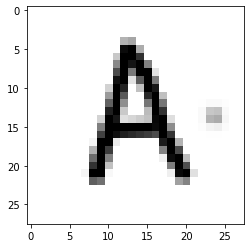

In [ ]:
img = cv2.imread(list(uploaded)[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray')
plt.show()

In [ ]:
#Inverse and normalize our image
img = abs(255-img) / 255


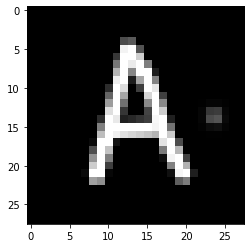

In [ ]:
plt.imshow(img,cmap='gray')
plt.show()

In [ ]:
img = img.reshape(1,28,28,1)

In [ ]:
predictions = []

for model in models:
  predictions.append(np.argmax(model.predict(img), axis=1)[0])

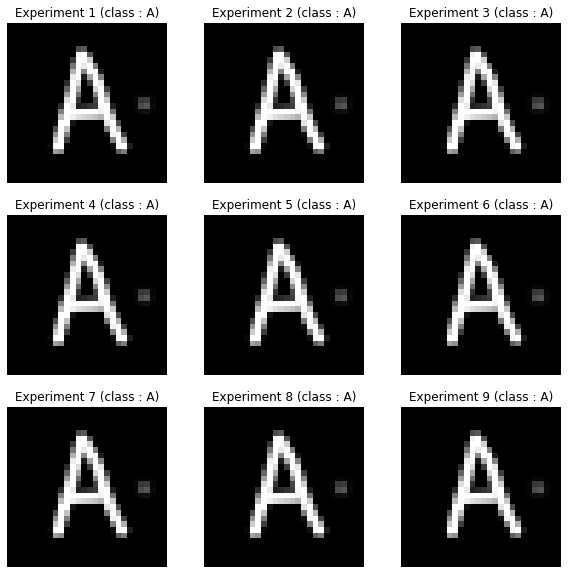

In [ ]:
emnist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

f, ax = plt.subplots(3, 3, figsize = (10, 10))
for i in range(0,9):
    
    label = emnist[predictions[i]]
    ax[i//3, i%3].imshow(tf.squeeze(img), cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Experiment {} (class : {})".format(i+1,label)) 
plt.show()